<a href="https://colab.research.google.com/github/chaerui7967/stock_predict_news_and_youtube/blob/master/lstm_%EC%9E%AC%EB%AC%B4%EC%A0%95%EB%B3%B4_%EC%85%80%ED%8A%B8%EB%A6%AC%EC%98%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 재무지표를 포함한 lstm 종가 예측

## 라이브러리 설치

In [1]:
# 필요 라이브러리 설치
!pip install finance-datareader
!pip install pykrx

     |████████████████████████████████| 81 kB 4.0 MB/s 
     |████████████████████████████████| 60 kB 6.2 MB/s 
     |████████████████████████████████| 251 kB 16.4 MB/s 


## 패키지 로딩 및 함수 로딩

In [2]:
# 필요 라이브러리
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 주식가격 로딩
import FinanceDataReader as fdr
from pykrx import stock

import datetime

In [3]:
def money_sur(stock_name, start, end):

  # 라이브러리를 찾음... 한방에 나옴...
    start_date = start
    end_date = end
    sample_code = stock_name

    dataset = fdr.DataReader(sample_code, start = start_date, end = end_date )
    dataset = dataset.reset_index()
    df = stock.get_market_fundamental_by_date(fromdate=start_date, todate=end_date, ticker=sample_code)
    df = df.reset_index()
    df.columns = ['Date','BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS']
    data = pd.merge(dataset, df, on='Date')

    return data

## 데이터 로드

In [4]:
end_date = datetime.datetime.now().strftime("%Y%m%d")
df = money_sur('068270',2018, end_date)

In [5]:
df

,Date,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS
0,2018-01-02,206047,209825,204757,208167,1176443,0.021709,16457,150.10,13.730000,1505,0.0,0
1,2018-01-03,210931,227794,209272,227334,2411162,0.092075,16457,163.92,14.990000,1505,0.0,0
2,2018-01-04,230007,240696,226044,230376,3265527,0.013381,16457,166.11,15.190000,1505,0.0,0
3,2018-01-05,234890,246041,234061,245949,1920918,0.067598,16457,177.34,16.219999,1505,0.0,0
4,2018-01-08,256637,279399,255440,278754,4298770,0.133381,16457,201.00,18.379999,1505,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,2021-09-10,269500,271000,265500,267500,394088,-0.005576,24262,71.22,11.030000,3756,0.0,0
912,2021-09-13,266500,267000,260500,262000,505510,-0.020561,24262,69.76,10.800000,3756,0.0,0
913,2021-09-14,261500,265000,260500,263000,416684,0.003817,24262,70.02,10.840000,3756,0.0,0
914,2021-09-15,266000,275500,265500,272500,576273,0.036122,24262,72.55,11.230000,3756,0.0,0


## 데이터 전처리

In [6]:
df1 = df.set_index('Date')

In [7]:
df1.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'BPS', 'PER', 'PBR',
       'EPS', 'DIV', 'DPS'],
      dtype='object')

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


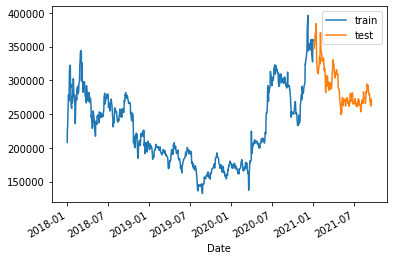

In [8]:
# test --> 21년 이후 , train --> 18~20
split_date = pd.Timestamp('01-01-2021')

train = df1.loc[:split_date, ]
test = df1.loc[split_date:, ]

ax = train['Close'].plot()
test['Close'].plot(ax=ax)
plt.legend(['train', 'test'])

In [9]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

train_sc

array([[0.29473818, 0.27584278, 0.31036672, ..., 0.        , 0.        ,
        0.        ],
       [0.31352792, 0.34564645, 0.32885604, ..., 0.        , 0.        ,
        0.        ],
       [0.3869172 , 0.39576648, 0.39753885, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.82243997, 0.83406236, 0.77480292, ..., 0.42974721, 0.        ,
        0.        ],
       [0.88895044, 0.87864674, 0.89286431, ..., 0.40623163, 0.        ,
        0.        ],
       [0.89664485, 0.87864674, 0.90924466, ..., 0.40623163, 0.        ,
        0.        ]])

In [10]:
df1.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'BPS', 'PER', 'PBR',
       'EPS', 'DIV', 'DPS'],
      dtype='object')

In [11]:
scale_cols = list(df1.columns)

train_sc_df = pd.DataFrame(train_sc, columns=[scale_cols], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=[scale_cols], index=test.index)

In [12]:
# 종가로만 예측 시
# train_close = pd.DataFrame(train_sc_df[('Close',)])
# test_close = pd.DataFrame(test_sc_df[('Close',)])

In [13]:
for i in scale_cols:
  for s in range(1, 13):  
    train_sc_df[(i+'shift_{}'.format(s),)] = train_sc_df[(i,)].shift(s)
    test_sc_df[(i+'shift_{}'.format(s),)] = test_sc_df[(i,)].shift(s)

train_sc_df.head(13)
train_sc_df.shape

(738, 156)

In [14]:
test_sc_df.shape

(178, 156)

In [15]:
train_sc_df.columns

MultiIndex([(       'Open',),
            (       'High',),
            (        'Low',),
            (      'Close',),
            (     'Volume',),
            (     'Change',),
            (        'BPS',),
            (        'PER',),
            (        'PBR',),
            (        'EPS',),
            ...
            ( 'DPSshift_3',),
            ( 'DPSshift_4',),
            ( 'DPSshift_5',),
            ( 'DPSshift_6',),
            ( 'DPSshift_7',),
            ( 'DPSshift_8',),
            ( 'DPSshift_9',),
            ('DPSshift_10',),
            ('DPSshift_11',),
            ('DPSshift_12',)],
           length=156)

In [16]:
train_sc_df.head(13)

,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS,Openshift_1,Openshift_2,Openshift_3,Openshift_4,Openshift_5,Openshift_6,Openshift_7,Openshift_8,Openshift_9,Openshift_10,Openshift_11,Openshift_12,Highshift_1,Highshift_2,Highshift_3,Highshift_4,Highshift_5,Highshift_6,Highshift_7,Highshift_8,Highshift_9,Highshift_10,Highshift_11,Highshift_12,Lowshift_1,Lowshift_2,Lowshift_3,Lowshift_4,...,PBRshift_9,PBRshift_10,PBRshift_11,PBRshift_12,EPSshift_1,EPSshift_2,EPSshift_3,EPSshift_4,EPSshift_5,EPSshift_6,EPSshift_7,EPSshift_8,EPSshift_9,EPSshift_10,EPSshift_11,EPSshift_12,DIVshift_1,DIVshift_2,DIVshift_3,DIVshift_4,DIVshift_5,DIVshift_6,DIVshift_7,DIVshift_8,DIVshift_9,DIVshift_10,DIVshift_11,DIVshift_12,DPSshift_1,DPSshift_2,DPSshift_3,DPSshift_4,DPSshift_5,DPSshift_6,DPSshift_7,DPSshift_8,DPSshift_9,DPSshift_10,DPSshift_11,DPSshift_12
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0.294738,0.275843,0.310367,0.286302,0.090132,0.420890,0.0,0.486603,0.423052,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.313528,0.345646,0.328856,0.359037,0.202977,0.609431,0.0,0.559069,0.504185,0.0,0.0,0.0,0.294738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.275843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.310367,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,0.386917,0.395766,0.397539,0.370580,0.281060,0.398577,0.0,0.570552,0.517064,0.0,0.0,0.0,0.313528,0.294738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.345646,0.275843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.328856,0.310367,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,0.405703,0.416530,0.430369,0.429677,0.158172,0.543847,0.0,0.629437,0.583387,0.0,0.0,0.0,0.386917,0.313528,0.294738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.395766,0.345646,0.275843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.397539,0.328856,0.310367,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,0.489368,0.546115,0.517918,0.554165,0.375491,0.720107,0.0,0.753500,0.722473,0.0,0.0,0.0,0.405703,0.386917,0.313528,0.294738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.416530,0.395766,0.345646,0.275843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.430369,0.397539,0.328856,0.310367,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-09,0.579774,0.606254,0.570749,0.519196,0.449512,0.274148,0.0,0.718630,0.683194,0.0,0.0,0.0,0.489368,0.405703,0.386917,0.313528,0.294738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.546115,0.416530,0.395766,0.345646,0.275843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.517918,0.430369,0.397539,0.328856,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-10,0.577288,0.588353,0.547349,0.531434,0.301322,0.394782,0.0,0.730848,0.697360,0.0,0.0,0.0,0.579774,0.489368,0.405703,0.386917,0.313528,0.294738,NaN,NaN,NaN,NaN,NaN,NaN,0.606254,0.546115,0.416530,0.395766,0.345646,0.275843,NaN,NaN,NaN,NaN,NaN,NaN,0.570749,0.517918,0.430369,0.397539,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-11,0.560634,0.559723,0.577543,0.569906,0.144530,0.462311,0.0,0.769178,0.739858,0.0,0.0,0.0,0.577288,0.579774,0.489368,0.405703,0

In [17]:
X_train = train_sc_df.dropna().drop(columns=scale_cols, axis=1)
y_train = train_sc_df.dropna()[['Close']]

X_test = test_sc_df.dropna().drop(columns=scale_cols, axis=1)
y_test = test_sc_df.dropna()[['Close']]

X_train.head()

,Openshift_1,Openshift_2,Openshift_3,Openshift_4,Openshift_5,Openshift_6,Openshift_7,Openshift_8,Openshift_9,Openshift_10,Openshift_11,Openshift_12,Highshift_1,Highshift_2,Highshift_3,Highshift_4,Highshift_5,Highshift_6,Highshift_7,Highshift_8,Highshift_9,Highshift_10,Highshift_11,Highshift_12,Lowshift_1,Lowshift_2,Lowshift_3,Lowshift_4,Lowshift_5,Lowshift_6,Lowshift_7,Lowshift_8,Lowshift_9,Lowshift_10,Lowshift_11,Lowshift_12,Closeshift_1,Closeshift_2,Closeshift_3,Closeshift_4,...,PBRshift_9,PBRshift_10,PBRshift_11,PBRshift_12,EPSshift_1,EPSshift_2,EPSshift_3,EPSshift_4,EPSshift_5,EPSshift_6,EPSshift_7,EPSshift_8,EPSshift_9,EPSshift_10,EPSshift_11,EPSshift_12,DIVshift_1,DIVshift_2,DIVshift_3,DIVshift_4,DIVshift_5,DIVshift_6,DIVshift_7,DIVshift_8,DIVshift_9,DIVshift_10,DIVshift_11,DIVshift_12,DPSshift_1,DPSshift_2,DPSshift_3,DPSshift_4,DPSshift_5,DPSshift_6,DPSshift_7,DPSshift_8,DPSshift_9,DPSshift_10,DPSshift_11,DPSshift_12
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-18,0.733635,0.710948,0.719812,0.652801,0.560634,0.577288,0.579774,0.489368,0.405703,0.386917,0.313528,0.294738,0.704699,0.715079,0.735485,0.799555,0.559723,0.588353,0.606254,0.546115,0.416530,0.395766,0.345646,0.275843,0.651127,0.736788,0.711505,0.669993,0.577543,0.547349,0.570749,0.517918,0.430369,0.397539,0.328856,0.310367,0.592633,0.711178,0.720271,0.690542,...,0.583387,0.517064,0.504185,0.423052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-19,0.597148,0.733635,0.710948,0.719812,0.652801,0.560634,0.577288,0.579774,0.489368,0.405703,0.386917,0.313528,0.618428,0.704699,0.715079,0.735485,0.799555,0.559723,0.588353,0.606254,0.546115,0.416530,0.395766,0.345646,0.625091,0.651127,0.736788,0.711505,0.669993,0.577543,0.547349,0.570749,0.517918,0.430369,0.397539,0.328856,0.612916,0.592633,0.711178,0.720271,...,0.722473,0.583387,0.517064,0.504185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-22,0.636497,0.597148,0.733635,0.710948,0.719812,0.652801,0.560634,0.577288,0.579774,0.489368,0.405703,0.386917,0.609117,0.618428,0.704699,0.715079,0.735485,0.799555,0.559723,0.588353,0.606254,0.546115,0.416530,0.395766,0.545085,0.625091,0.651127,0.736788,0.711505,0.669993,0.577543,0.547349,0.570749,0.517918,0.430369,0.397539,0.502761,0.612916,0.592633,0.711178,...,0.683194,0.722473,0.583387,0.517064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-23,0.498232,0.636497,0.597148,0.733635,0.710948,0.719812,0.652801,0.560634,0.577288,0.579774,0.489368,0.405703,0.498501,0.609117,0.618428,0.704699,0.715079,0.735485,0.799555,0.559723,0.588353,0.606254,0.546115,0.416530,0.492631,0.545085,0.625091,0.651127,0.736788,0.711505,0.669993,0.577543,0.547349,0.570749,0.517918,0.430369,0.477582,0.502761,0.612916,0.592633,...,0.697360,0.683194,0.722473,0.583387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-24,0.518796,0.498232,0.636497,0.597148,0.733635,0.710948,0.719812,0.652801,0.560634,0.577288,0.579774,0.489368,0.535016,0.498501,0.609117,0.618428,0.704699,0.715079,0.735485,0.799555,0.559723,0.588353,0.606254,0.546115,0.542067,0.492631,0.545085,0.625091,0.651127,0.736788,0.711505,0.669993,0.577543,0.547349,0.570749,0.517918,0.541927,0.477582,0.502761,0.612916,...,0.739858,0.697360,0.683194,0.722473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
print(type(X_train))
X_train = X_train.values
print(type(X_train))
X_test= X_test.values
y_train = y_train.values
y_test = y_test.values
 

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
(726, 144)
(726, 1)
(166, 144)
(166, 1)


In [19]:
X_train_t = X_train.reshape(X_train.shape[0], 12, 12)
X_test_t = X_test.reshape(X_test.shape[0], 12, 12)

## LSTM 실행

### tensor 사용해서 window 만들기

In [ ]:
# import tensorflow as tf

# def windowed_dataset(series, window_size, batch_size, shuffle):
#     series = tf.expand_dims(series, axis=-1)
#     ds = tf.data.Dataset.from_tensor_slices(series)
#     ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
#     ds = ds.flat_map(lambda w: w.batch(window_size + 1))
#     if shuffle:
#         ds = ds.shuffle(1000)
#     ds = ds.map(lambda w: (w[:-1], w[-1]))
#     return ds.batch(batch_size).prefetch(1)

# WINDOW_SIZE=20
# BATCH_SIZE=32

In [ ]:
# # trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
# train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
# test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
# # X: (batch_size, window_size, feature)
# # Y: (batch_size, feature)
# for data in train_data.take(1):
#     print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
#     print(f'데이터셋(Y) 구성(batch_size, feature갯수): {data[1].shape}')

### 모델

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()

model.add(LSTM(64,
               input_shape = (12, 12),
               return_sequences= True))
model.add(LSTM(64,
               return_sequences = False))
model.add(Dense(32, activation = 'tanh'))
model.add(Dense(1))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 64)            19712     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 54,849
Trainable params: 54,849
Non-trainable params: 0
_________________________________________________________________


In [22]:
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

# earlystopping은 30번 epoch통안 val_loss 개선이 없다면 학습 중지
earlystopping = EarlyStopping(monitor='val_loss', patience=30)
# val_loss 기준 체크포인터도 생성
filename = 'lstm_cel.h5'
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [23]:
history = model.fit(X_train_t, y_train, validation_data=(X_test_t,y_test),
                    epochs=300, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/300
23/23 [==============================] - 9s 52ms/step - loss: 0.0158 - mse: 0.0315 - val_loss: 0.0104 - val_mse: 0.0209

Epoch 00001: val_loss improved from inf to 0.01043, saving model to lstm_cel.h5
Epoch 2/300
23/23 [==============================] - 0s 12ms/step - loss: 0.0062 - mse: 0.0125 - val_loss: 0.0039 - val_mse: 0.0078

Epoch 00002: val_loss improved from 0.01043 to 0.00390, saving model to lstm_cel.h5
Epoch 3/300
23/23 [==============================] - 0s 14ms/step - loss: 0.0030 - mse: 0.0060 - val_loss: 0.0050 - val_mse: 0.0100

Epoch 00003: val_loss did not improve from 0.00390
Epoch 4/300
23/23 [==============================] - 0s 12ms/step - loss: 0.0013 - mse: 0.0026 - val_loss: 0.0048 - val_mse: 0.0096

Epoch 00004: val_loss did not improve from 0.00390
Epoch 5/300
23/23 [==============================] - 0s 12ms/step - loss: 0.0012 - mse: 0.0025 - val_loss: 0.0052 - val_mse: 0.0105

Epoch 00005: val_loss did not improve from 0.00390
Epoch 6/300
23/23 

In [24]:
X_test_t

array([[[0.68697221, 0.7619927 , 0.84470759, ..., 0.87548523,
         0.8543256 , 0.8543256 ],
        [0.69218249, 0.80483797, 0.81843432, ..., 0.85728104,
         0.84368469, 0.83785768],
        [0.68606237, 0.75772641, 0.80481992, ..., 0.91948238,
         0.88467413, 0.87648396],
        ...,
        [0.40623163, 0.40623163, 0.40623163, ..., 0.40623163,
         0.40623163, 0.40623163],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.71582624, 0.68697221, 0.7619927 , ..., 0.86779082,
         0.87548523, 0.8543256 ],
        [0.71937519, 0.69218249, 0.80483797, ..., 0.85728104,
         0.85728104, 0.84368469],
        [0.73315588, 0.68606237, 0.75772641, ..., 0.90924466,
         0.91948238, 0.88467413],
        ...,
        [0.40623163, 0.40623163, 0.40623163, ..., 0.40623163,
         0.40623163, 0.40623163],
        [0. 

In [25]:
model.load_weights(filename)
pred = model.predict(X_test_t)

In [26]:
def reverse_min_max_scaling(org_x, x): #종가 예측값
    org_x_np = np.asarray(org_x) 
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [27]:
pred.shape

(166, 1)

In [28]:
test_ttt = test['Close'][-2]

In [29]:
pred_act = reverse_min_max_scaling(test_ttt, pred[-2])

In [30]:
pred_act.shape

(1,)

In [31]:
pred_act, test_ttt

(array([272500.00000005]), 272500)

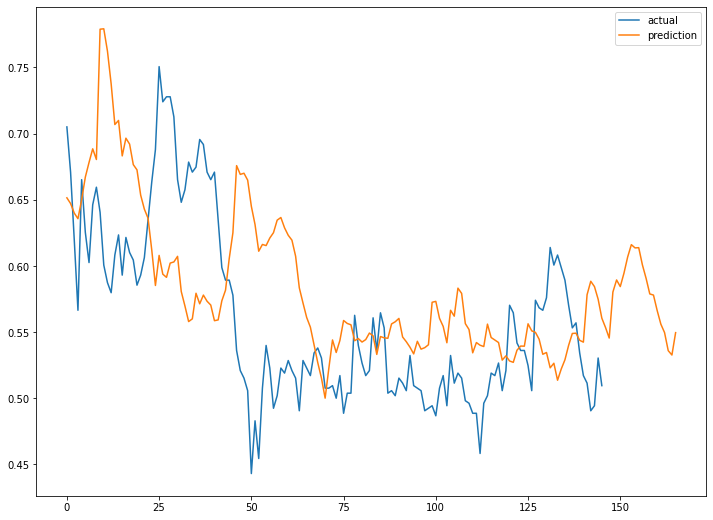

In [32]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [33]:
score = model.evaluate(X_test_t,y_test,batch_size=30)
print(score)

6/6 [==============================] - 0s 5ms/step - loss: 0.0010 - mse: 0.0021
[0.0010337095009163022, 0.0020674190018326044]


In [34]:
test_sc_df[('Close',)].describe()

count    178.000000
mean       0.600391
std        0.110198
min        0.443152
25%        0.515253
50%        0.565534
75%        0.670840
max        0.953552
Name: (Close,), dtype: float64

In [35]:
pd.DataFrame(pred).describe()

,0
count,166.000000
mean,0.583863
std,0.054608
min,0.500109
25%,0.543852
50%,0.564179
75%,0.613248
max,0.779110


Text(0.5, 1.0, 'Prices vs Predicted price Index: $Y_i$ vs $\\hat{Y}_i$')

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


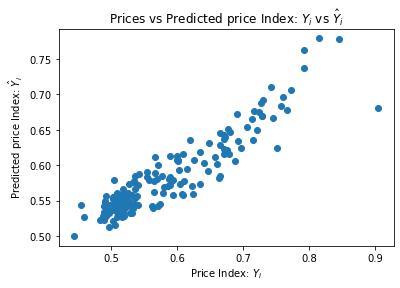

In [36]:
# 직선에 가까울 수록 정확도가 높다
y_pred = model.predict(X_test_t, batch_size=32)
plt.scatter(y_test, y_pred)
plt.xlabel("Price Index: $Y_i$")
plt.ylabel("Predicted price Index: $\hat{Y}_i$")
plt.title("Prices vs Predicted price Index: $Y_i$ vs $\hat{Y}_i$")